<a href="https://colab.research.google.com/github/benardt/ML/blob/main/oring_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import shutil
shutil.unpack_archive("/content/drive/My Drive/data/test.zip", "/tmp")

Mounted at /content/drive


In [2]:
! pip install thop 1>/dev/null

import os
import time
import datetime
from PIL import Image, ImageOps

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np

import thop
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses
!pip install import-ipynb
import import_ipynb
from importlib import reload # reload 

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=70c818a02e56935c615906e4c3a106d59b67230c1717528e7f0e6caf49605971
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [4]:
!rm -r './mylib.ipynb'
!cp '/content/drive/My Drive/Colab Notebooks/mylib.ipynb' .
import mylib as ml
reload(ml)
ml.mytest('This is a test.')

rm: cannot remove './mylib.ipynb': No such file or directory
importing Jupyter notebook from mylib.ipynb
importing Jupyter notebook from mylib.ipynb
test import... This is a test.


In [5]:
FOLDER = 'oring11'

OUTPUT_SIZE = 63
BATCH_SIZE = 32
EPOCHS = 15

shutil.unpack_archive('/content/drive/My Drive/data/'+FOLDER+'.zip', '/tmp')

def get_data(isprint=False):

    trans_in = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                          transforms.ToTensor()])
    
    interpol = transforms.InterpolationMode.NEAREST
    trans_out = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                          transforms.Resize(OUTPUT_SIZE,interpolation=interpol),
                          transforms.ToTensor()])   

    class OringLandmarksDataset(Dataset):
        """Landmarks dataset."""

        def __init__(self, root_dir):
            """
            Args:
                root_dir (string): Directory with all the images.
            """

            self.root_dir = root_dir
            self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "PNGImages"))))
            self.masks = list(sorted(os.listdir(os.path.join(root_dir, "Masks"))))

        def __len__(self):
            return len(self.imgs)

        def transform(self, x, y):

            image = trans_in(x)
            mask = trans_out(y)
            #mask = 1.0 * (maskt > 0.25)
            return image, mask

        def __getitem__(self, idx):
            if torch.is_tensor(idx):
                idx = idx.tolist()

            img_name = os.path.join(self.root_dir, "PNGImages", self.imgs[idx])
            im_invert = Image.open(img_name).convert('L')
            image = ImageOps.invert(im_invert)

            path = self.imgs[idx]

            mask_name = os.path.join(self.root_dir, "Masks", self.masks[idx])
            mask_invert = Image.open(mask_name).convert('L')
            mask = ImageOps.invert(mask_invert)

            x, y = self.transform(image, mask)
            return x, y

    trans_dataset = OringLandmarksDataset(root_dir='/tmp/'+FOLDER)

    train_len = int(0.6*len(trans_dataset))
    valid_len = len(trans_dataset)-train_len
    TrainData, ValidData = torch.utils.data.random_split(trans_dataset,[train_len, valid_len])

    mydataloader = { 'train':[],'valid':[]}
    mydataloader['train'] = DataLoader(TrainData, batch_size=BATCH_SIZE,
                            shuffle=True, pin_memory=True,num_workers=2)
    mydataloader['valid'] = DataLoader(ValidData, batch_size=BATCH_SIZE,
                            shuffle=True, pin_memory=True,num_workers=2)

    if isprint:
      for i_batch, (x,y) in enumerate(mydataloader['train']):
        print(i_batch, x[0].size(), y[0].size())
        x = transforms.functional.resize(x, OUTPUT_SIZE)
        ml.images_show(x[0],y[0],5)
        if i_batch == 2:
          break

    return mydataloader

dataloader = get_data(isprint=False)


In [10]:
def define_model():

  layers = []

  # 1st layer
  layers.append(nn.Conv2d(1,64,31,1,15))
  layers.append(nn.MaxPool2d(15,2,7))

  # 2nd layer
  layers.append(nn.Conv2d(64,128,7,1,3))
  layers.append(nn.MaxPool2d(7,2,3))

  # 3rd layer
  layers.append(nn.Conv2d(128,64,5,1,2))
  layers.append(nn.MaxPool2d(5,2,2))

  # last layer
  layers.append(nn.Conv2d(64,1,1,1,0))

  return nn.Sequential(*layers)

model = define_model().to(device)

In [11]:

def objective():
    accuracy = ml.DiceLoss()
    liveloss = PlotLosses()
   

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

    #past_date = datetime.datetime.now().replace(microsecond=0)

    all_logs = []
    for epoch in range(EPOCHS):
        logs = {}
        for phase in ['train', 'valid']:

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(iter(dataloader[phase]), total=len(dataloader[phase]))
            counter = 0
            for x, y in tk0:
                x,y = x.to(device),y.to(device)

                if phase == 'train':
                    model.train()
                    yhat = model(x)
                    loss = criterion(yhat, y)
                    for param in model.parameters():
                        param.grad = None
                    loss.backward()
                    optimizer.step()

                else:
                    model.eval()
                    with torch.no_grad():
                        yhat = model(x)
                        loss = criterion(yhat, y)

                # loss
                running_loss += loss.detach() * x.detach().size(0)
                # accuracy
                preds = (yhat.detach() > 0.0)*1
                acc = 100*(1 - accuracy(preds, y.detach()))
                running_corrects += acc * x.detach().size(0)

                counter += 1
                tk0.set_postfix(loss=(running_loss / (counter * x.detach().size(0))))

            epoch_loss = running_loss.item() / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.item() / len(dataloader[phase].dataset)

            prefix = ''
            if phase == 'valid':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss
            logs[prefix + 'accuracy'] = epoch_acc

        all_logs.append(logs)
        liveloss.update(logs)
        liveloss.send()

    # future_date = datetime.datetime.now().replace(microsecond=0)
    # difference = (future_date - past_date)
    # total_seconds = int(difference.total_seconds())

    flops, _params = thop.profile(model, inputs=(torch.randn(1, 1, 500, 500).to(device),), verbose=False)
    return flops, epoch_acc


Batch size:  32
Model description:
Sequential(
  (0): Conv2d(1, 64, kernel_size=(31, 31), stride=(1, 1), padding=(15, 15))
  (1): MaxPool2d(kernel_size=15, stride=2, padding=7, dilation=1, ceil_mode=False)
  (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (3): MaxPool2d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
  (4): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): MaxPool2d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

Model parameters:

Check images:
torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


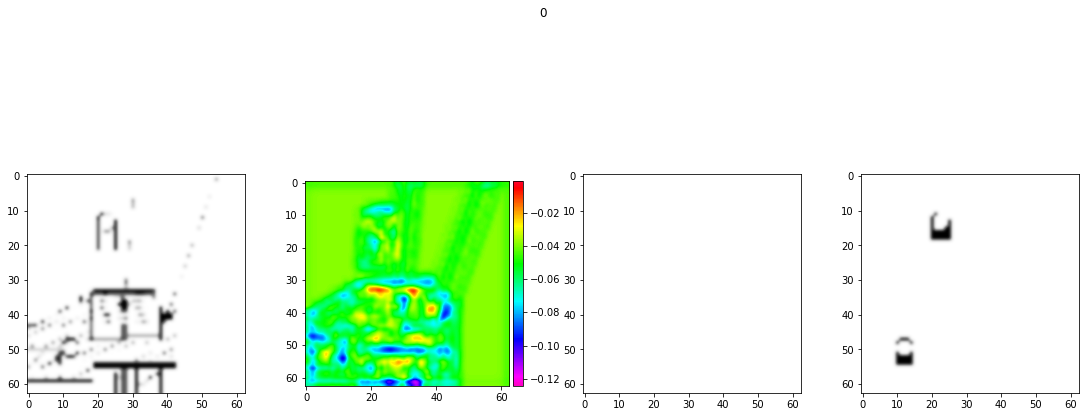

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


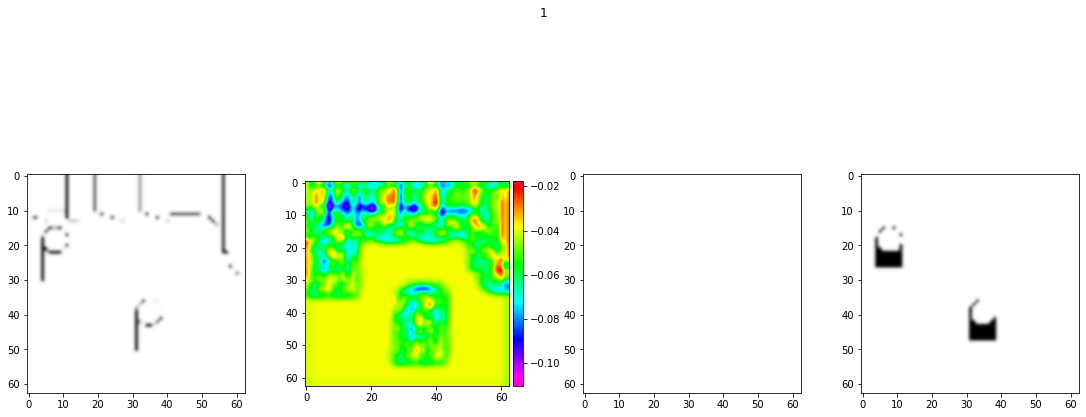

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


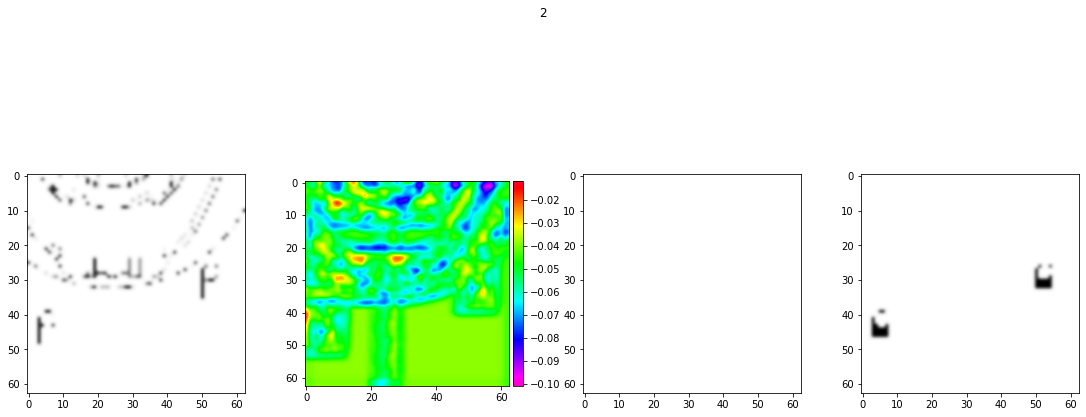

0

In [12]:

data=iter(dataloader['train']).next()
print('Batch size: ',data[0].size()[0])
print('Model description:')
print(model)
print('\nModel parameters:')

# mydict = {'batch_size': data[0].size()[0],
#           'date': datetime.datetime.now().replace(microsecond=0),
#           'model': str(model),
#           'nb_param': size,
#           'results': [],
#           'duration': 0,
#           'dataset': FOLDER,
#           'epoch':0}

ml.display(model,dataloader,device,2,1)


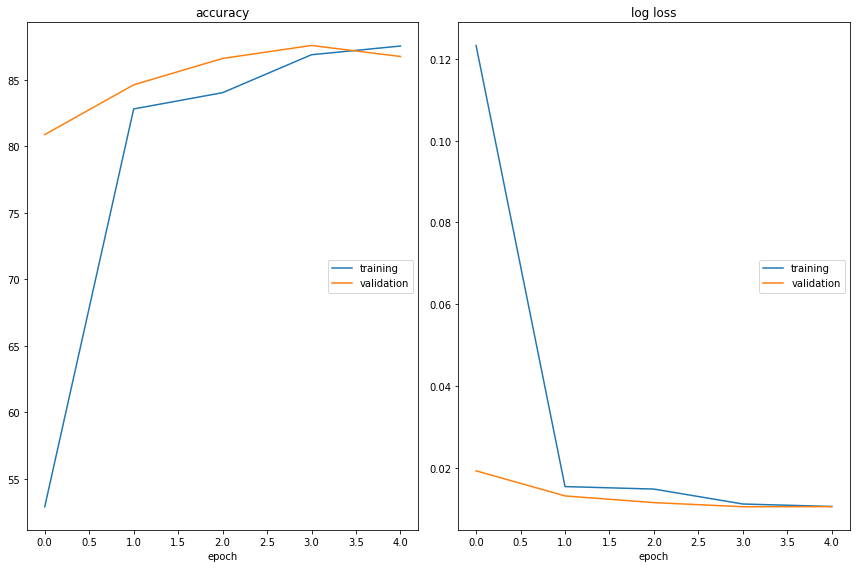

accuracy
	training         	 (min:   52.902, max:   87.534, cur:   87.534)
	validation       	 (min:   80.875, max:   87.577, cur:   86.747)
log loss
	training         	 (min:    0.011, max:    0.123, cur:    0.011)
	validation       	 (min:    0.010, max:    0.019, cur:    0.010)


KeyboardInterrupt: ignored

In [13]:
torch.cuda.empty_cache()

#duration,logs = train_model(model,dataloader)
flops, epoch_acc = objective()


In [ ]:
mydict['results'] = logs
mydict['duration'] = duration
mydict['epoch'] = 15

filename = str(datetime.datetime.now().replace(microsecond=0))

print(mydict)

import pickle
DIR = '/content/drive/My Drive/data/project/'

with open(DIR+filename+'.pkl', 'wb') as handle:
    pickle.dump(mydict, handle)




Check images:
torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


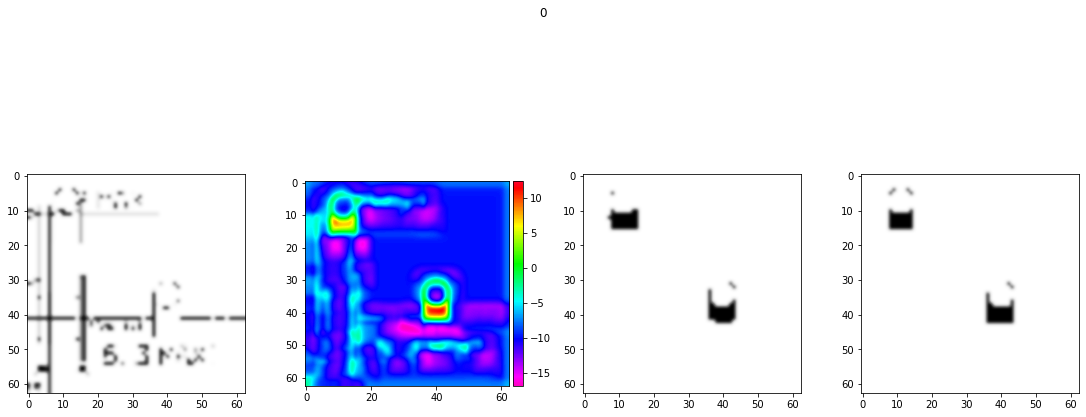

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


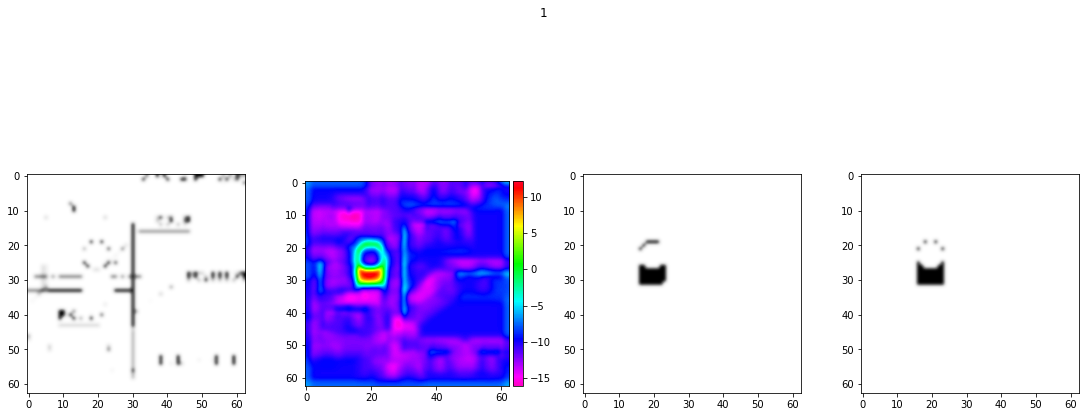

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


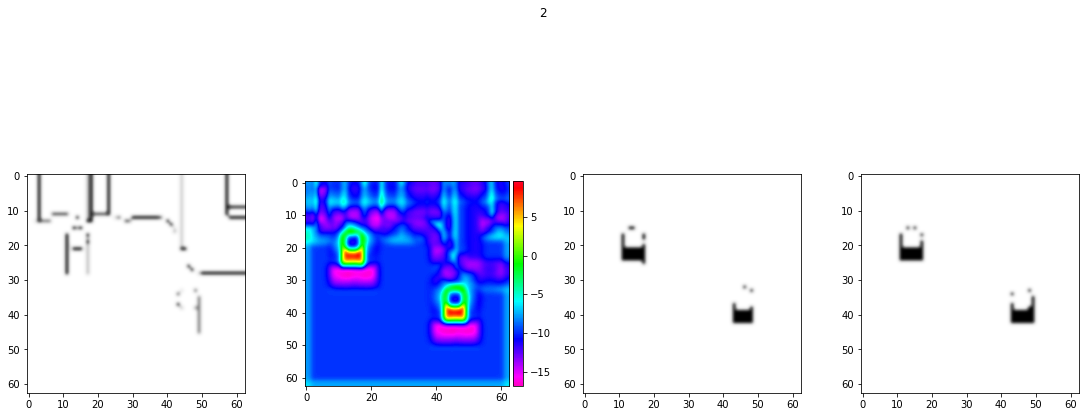

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


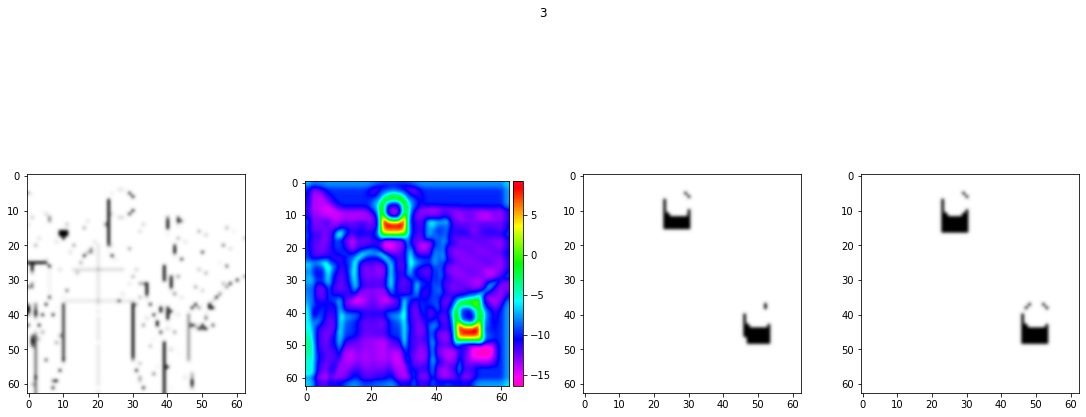

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


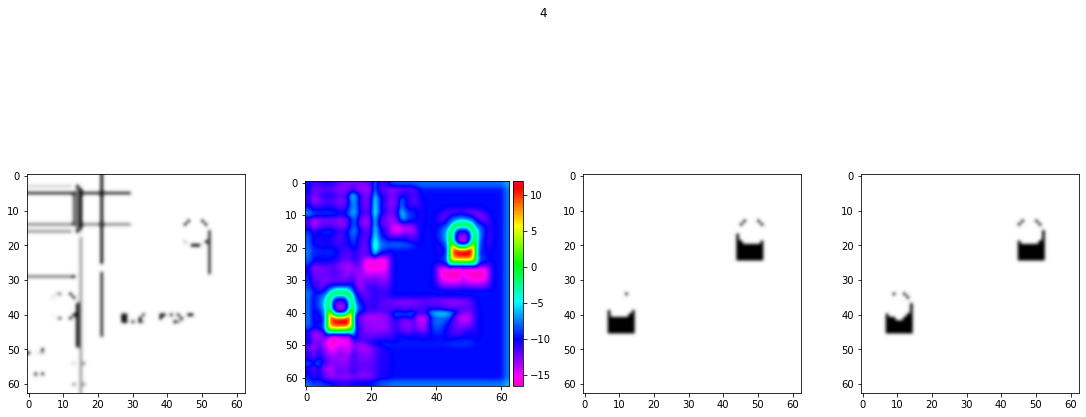

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


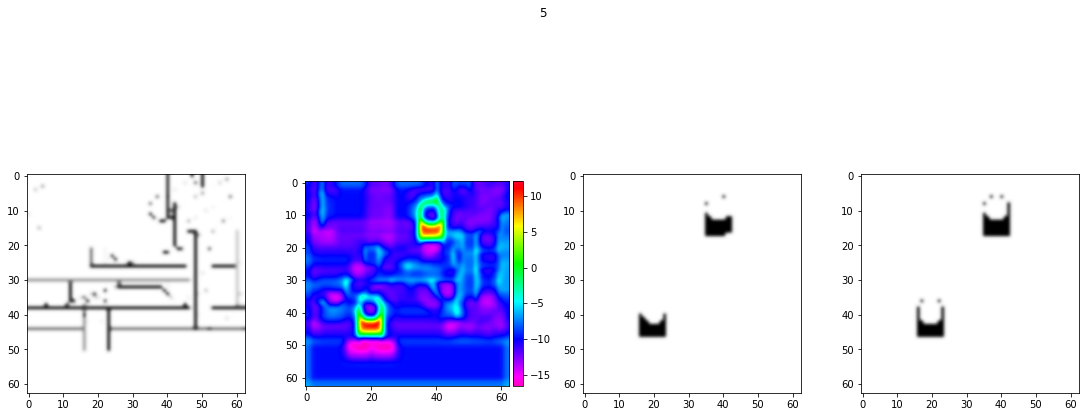

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


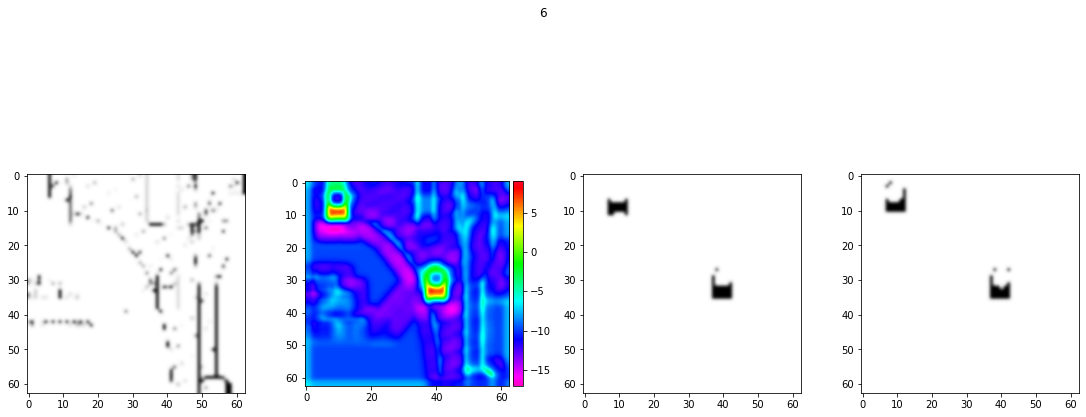

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


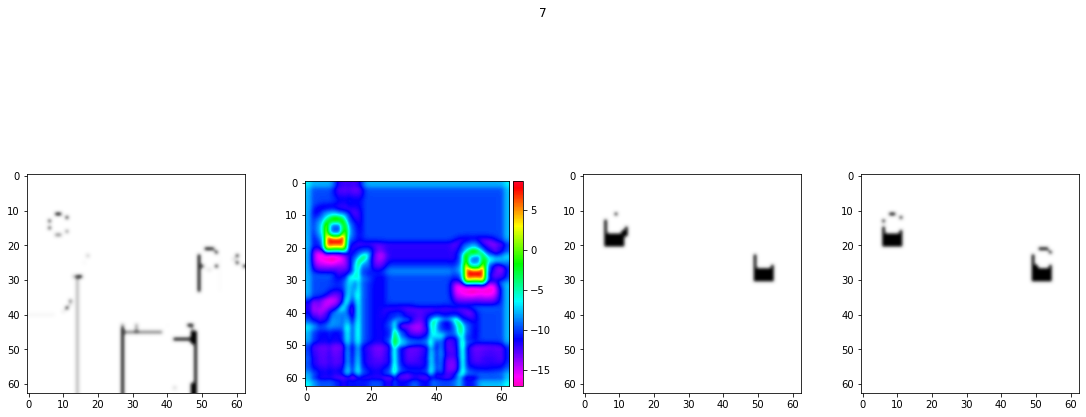

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


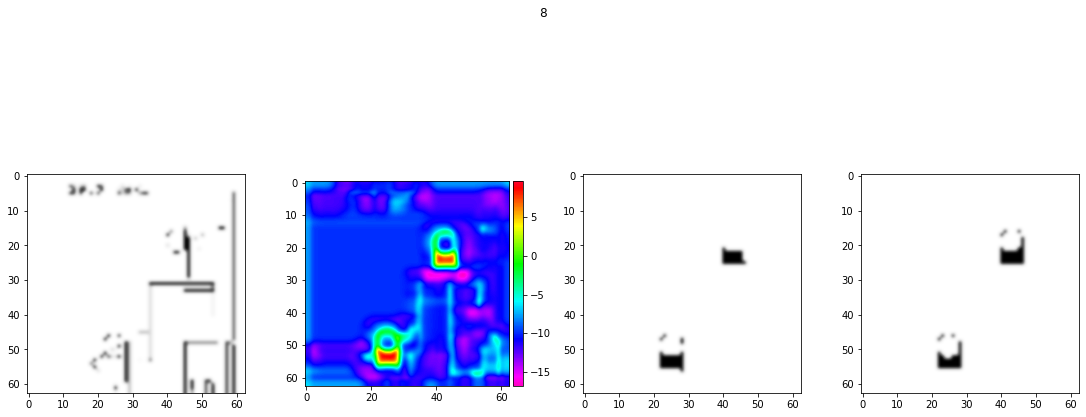

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


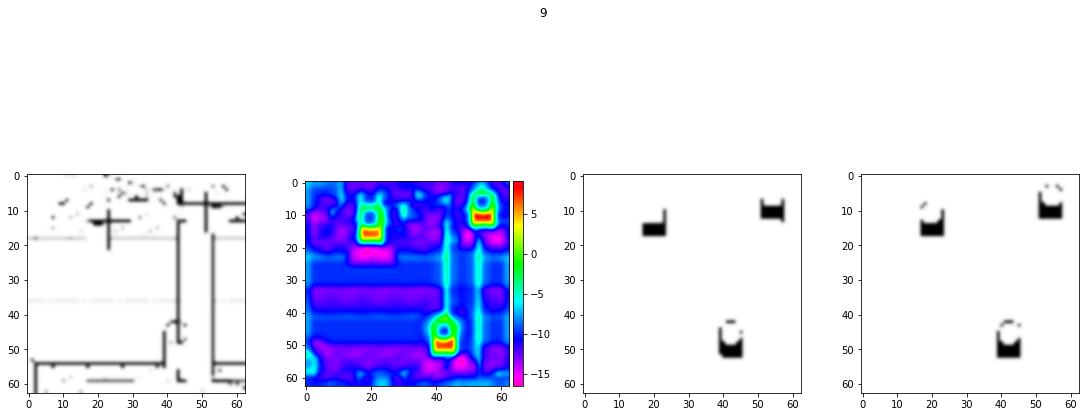

torch.Size([32, 1, 500, 500]) torch.Size([32, 1, 63, 63])


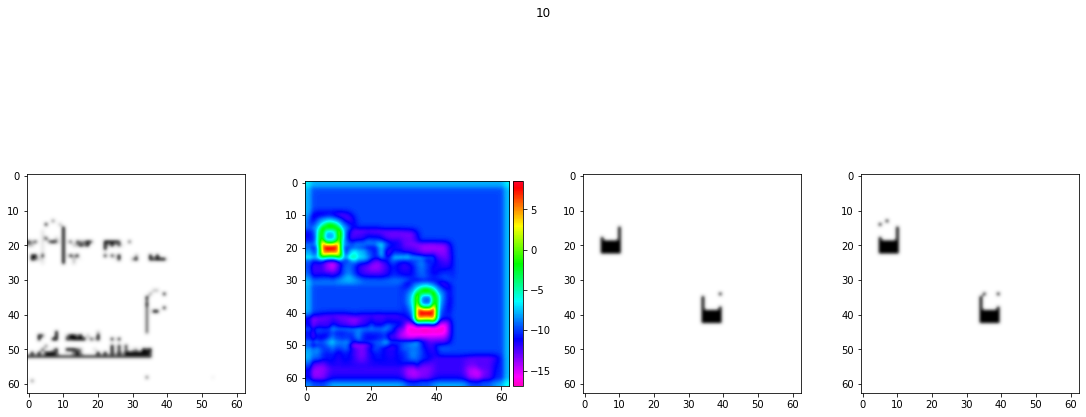

0

In [14]:
torch.cuda.empty_cache()
ml.display(model,dataloader,device,10,1)


Le code suivant retourne l'image originale associée aux sorties des différentes couches de convolution et maxPooling. Chaque colonne correspond à un filtre, l'image en haut de chaque colonne correspond à la sortie de la couche, les trois images en dessous correspondent aux zones de l'image originale que le filtre correspondant active le plus.

In [ ]:
def getPatch(target,batch,idx=0,topk=3):
    with torch.no_grad():
        img, label = batch
        img=img[idx].to(device)
        label = label[idx].to(device)

        conv_output = None
        x=img.unsqueeze(0)
        modules=[]

        for module_pos, module in model._modules.items():
            modules.append(module)
            x = module(x)  # Forward

            if module == target:
                break
        # img = unnormalize(img)
        fig = plt.figure(figsize=(16,8))
        fig.add_subplot(topk+2,x.size()[1], 1)
        tr=transforms.ToPILImage()
        im=tr(img.cpu())
        trr = transforms.Resize((244,244))
        im=trr(im)
        plt.imshow(np.array(im))
        for i in range(x.size()[1]):
            fig.add_subplot(topk + 2, x.size()[1], x.size()[1]+i+1)
            x=x.cpu()
            plt.imshow(x[0][i],cmap="afmhot") #cmap="viridis" (autre jeu de couleur)
            plt.axis('off')
            l=x[0][i].view(-1).sort(dim=(0), descending=True)
            best=l[1][:min(topk,l[1].size()[-1])]
            l=[(int(np.floor(best[j]/x.size()[-1]).item()),(best[j]%x.size()[-1]).item()) for j in range(best.size()[-1])]
            for j in range(len(l)):
                idx=l[j]
                crop=_getCropFor(img,idx,modules)
                crop = trr(crop)
                fig.add_subplot(topk + 2, x.size()[1], (j+2)*x.size()[1]+i+1)
                plt.imshow(np.array(crop))
                plt.axis('off')

        plt.show()
        
        
def _getCropFor(img,idx,modules):
    r,c=idx
    interest=(r,c,1,1)
    for m in range(len(modules)-1,-1,-1):
        mo=modules[m]
        if not ((isinstance(mo,torch.nn.Conv2d)) or (isinstance(mo,torch.nn.AvgPool2d))):
          continue
        size=mo.kernel_size
        if isinstance(size,int):
            size=(size,size)
        stride = mo.stride
        if isinstance(stride, int):
            stride=(stride,stride)
        pad=mo.padding
        if isinstance(pad, int):
            pad=(pad,pad)
        r,c,w,h=interest
        newr=r*stride[0]-pad[0]
        newc=c*stride[1]-pad[1]
        neww = (c + w -1) * stride[1] - pad[1] + size[1]-newc
        newh = (r + h-1) * stride[0] - pad[0] + size[0] - newr
        if newr<0:
            newh=newh-np.abs(newr)
            newr=0
        if newc<0:
            neww = neww - np.abs(newc)
            newc=0
        interest=(newr,newc,neww,newh)

    r, c, w, h = interest
    if c+w>img.size()[2]:
        w=img.size()[2]-c
    if r + h > img.size()[1]:
        h = img.size()[1] - r
    tr = transforms.ToPILImage()
    img=tr(img.cpu())
    img=transforms.functional.crop(img, r, c, h, w)
    #print(r, c, h, w)
    return img

In [ ]:
data=iter(dataloader['train']).next()
getPatch(model.conv1,data)
# getPatch(model.pool1, data)
# getPatch(model.conv2,data)
# getPatch(model.pool2, data)
# getPatch(model.conv3,data)
# getPatch(model.pool3, data)
getPatch(model.conv4,data)

In [ ]:
# Visualize conv filter

kernels = model.conv1.weight.detach()
print(kernels.size())

fig = plt.figure(figsize=(16,8))

n = 1
for idx in range(kernels.size(0)):
  for jdx in range(kernels.size(1)):
    #fig.add_subplot(kernels.size(1),kernels.size(0), n)
    fig.add_subplot(8,16, n)
    plt.imshow(2*kernels[idx][jdx].cpu().detach())
    plt.axis('off')
    n += 1
    # if n == 15:
    #   break

del kernels

kernels = model.conv2.weight.detach()
print(kernels.size())

fig = plt.figure(figsize=(16,8))


n = 1
for idx in range(kernels.size(0)):
  for jdx in range(kernels.size(1)):
    fig.add_subplot(16,64, n)
    plt.imshow(kernels[idx][jdx].cpu().detach())
    plt.axis('off')
    n += 1

    if n == 1024+1:
      break
  if n == 1024+1:
    break
    


In [ ]:
# Visualize feature maps

idx = 5
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = ValidData[idx]
data.unsqueeze_(0)
data= data.to(device)
output = model(data)

print(data.size())
print(output.size())

act = activation['conv2'].squeeze()

print(act.size())
fig = plt.figure(figsize=(16,16))
n=1
for idx in range(act.size(0)):
    #fig.add_subplot(1,act.size(0), n)
    fig.add_subplot(4,16, n)
    plt.imshow(act[idx].cpu())
    n += 1


In [ ]:
for name,_ in model.named_modules():
    print(name)

In [15]:
# Test data

DATA_DIR_TEST = '/tmp/test'

trans_input = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                      #transforms.Resize(INPUT_SIZE,interpolation=transforms.InterpolationMode.NEAREST),
                      transforms.ToTensor()])

class OringTestDataset(Dataset):

    def __init__(self, root_dir):

        self.root_dir = root_dir
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, "."))))

    def __len__(self):
        return len(self.imgs)

    def transform(self, x):
        image = trans_input(x)
        return image

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, ".", self.imgs[idx])
        im_invert = Image.open(img_name).convert('L')
        image = ImageOps.invert(im_invert)
        path = self.imgs[idx]
        x = self.transform(image)
        return x

test_dataset = OringTestDataset(root_dir=DATA_DIR_TEST)
testloader = DataLoader(test_dataset,batch_size=1,shuffle=False,pin_memory=False,num_workers=0)


Sequential(
  (0): Conv2d(1, 64, kernel_size=(31, 31), stride=(1, 1), padding=(15, 15))
  (1): MaxPool2d(kernel_size=15, stride=2, padding=7, dilation=1, ceil_mode=False)
  (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (3): MaxPool2d(kernel_size=7, stride=2, padding=3, dilation=1, ceil_mode=False)
  (4): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): MaxPool2d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)


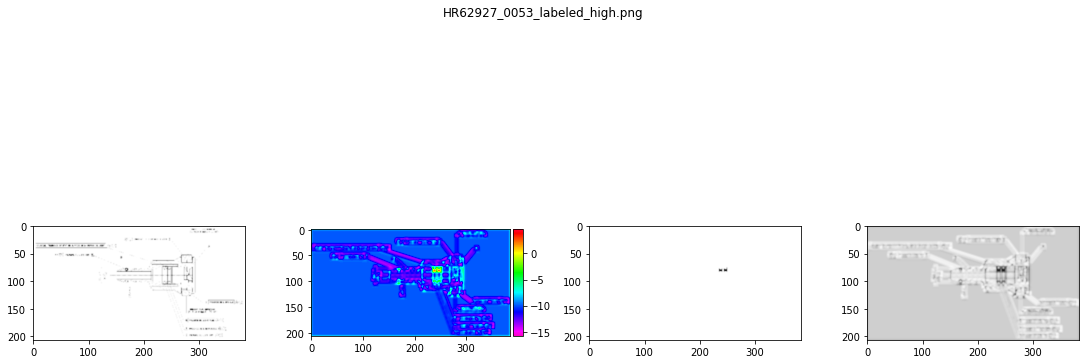

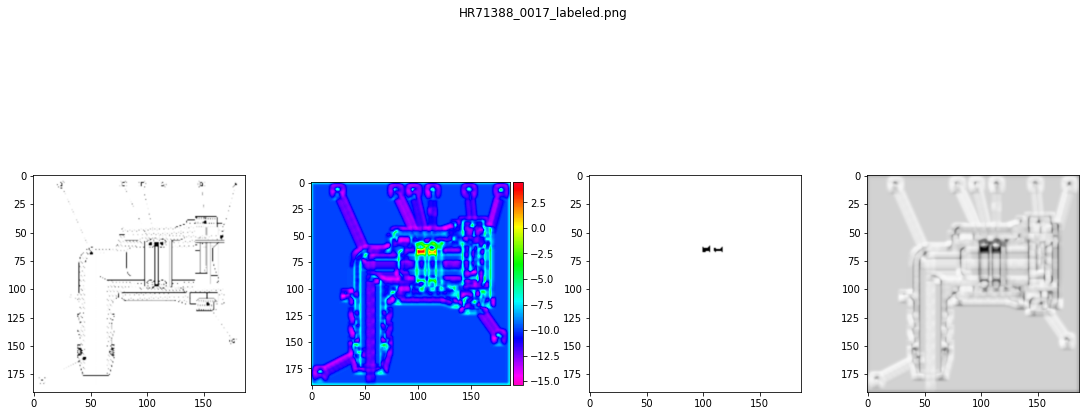

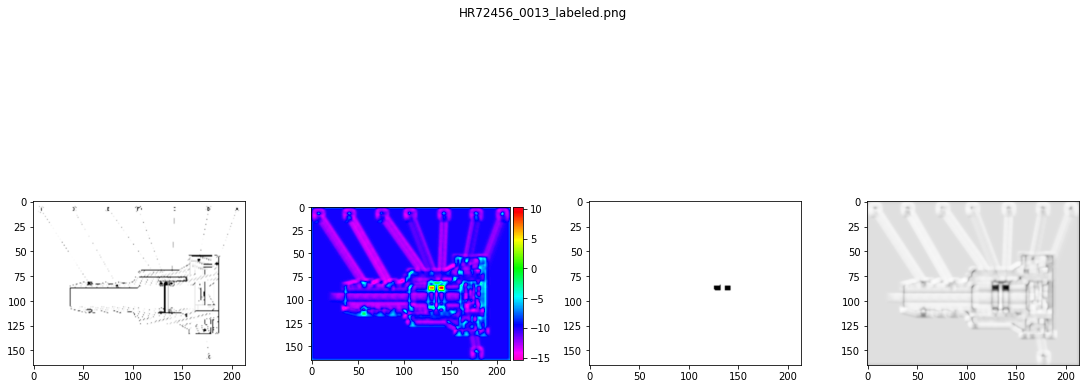

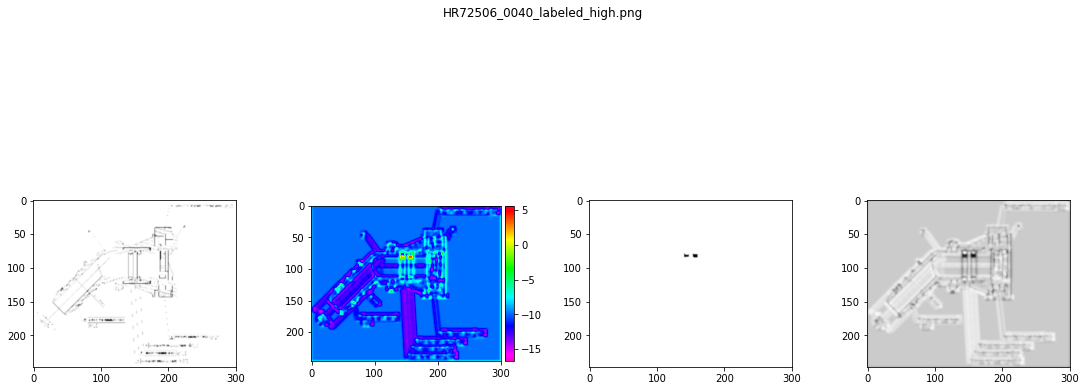

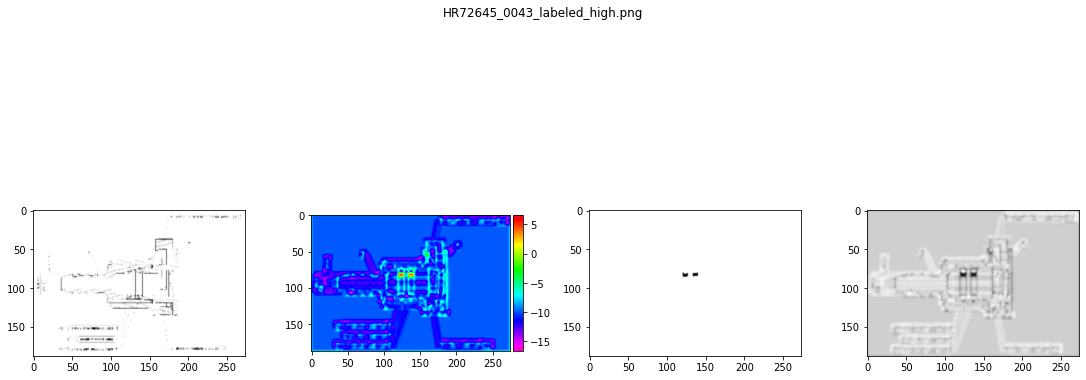

In [16]:
print(model)
model.eval()
with torch.no_grad():
    for i, x in enumerate(testloader):
        sample_fname = testloader.dataset.imgs[i]
        x=x.to(device)
        out = model(x)
        x = transforms.functional.resize(x, (out.size()[2],out.size()[3]))
        ml.tensShow(x.squeeze(0),out.squeeze(0),out.squeeze(0),sample_fname, 0.1)
        if i == 10:
            break


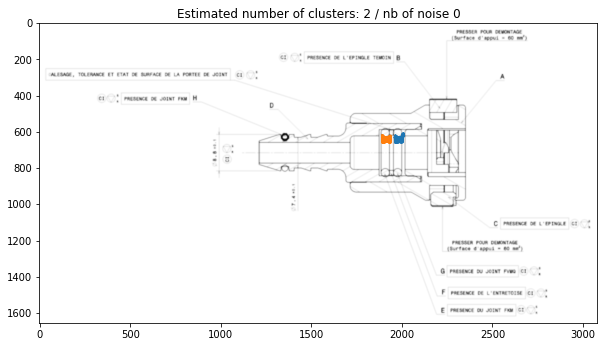

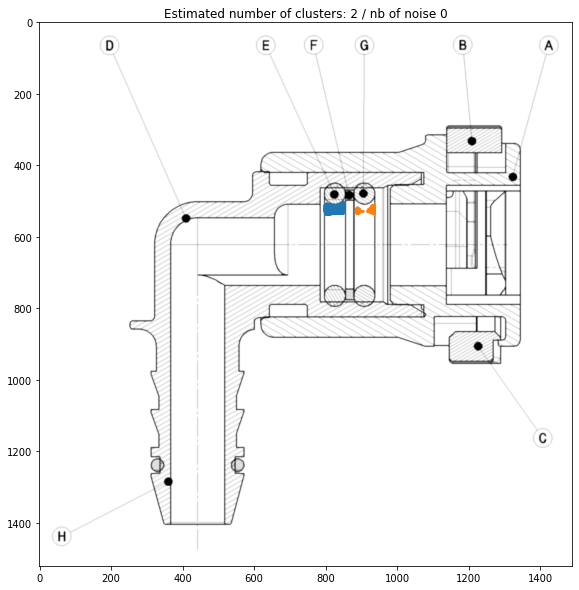

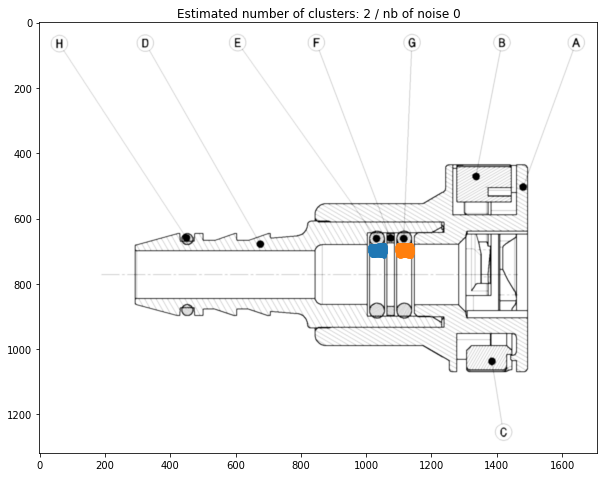

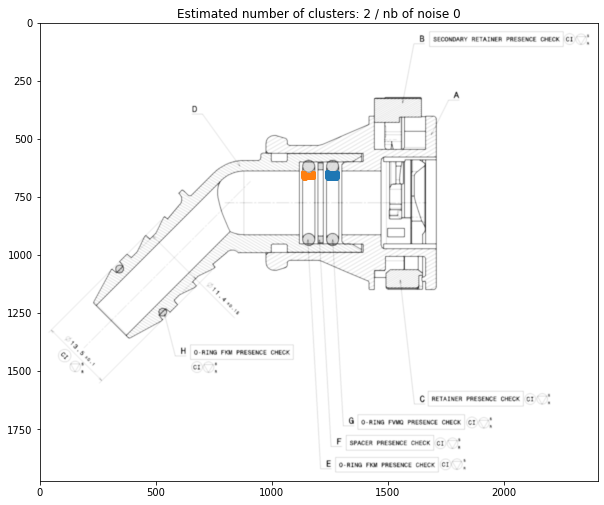

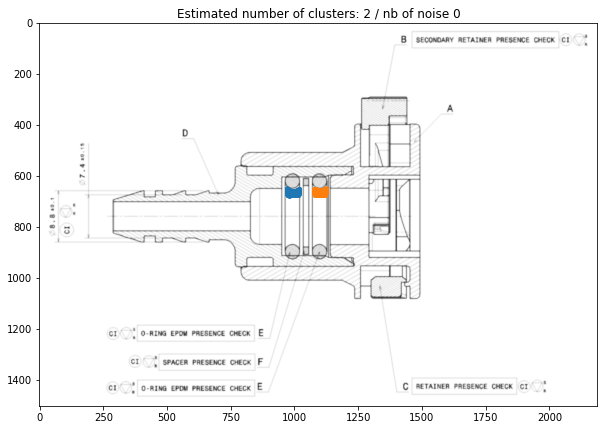

In [18]:
from sklearn.cluster import DBSCAN

model.eval()
stop = 5
idx = 0
with torch.no_grad():
    for inc, x in enumerate(testloader):
        sample_fname = testloader.dataset.imgs[i]
        x=x.to(device)
        out = model(x)
        #x = transforms.functional.resize(x, (out.size()[2],out.size()[3]))
        out = transforms.functional.resize(out, (x.size()[2],x.size()[3]))

        imx = x[idx].cpu().detach().numpy()
        imx = np.squeeze(imx)

        img = out[idx].cpu().detach().numpy()
        img = np.squeeze(img)
        
        X = np.column_stack(np.where(img > 1))

        if len(X) != 0:

          db = DBSCAN(eps=15, min_samples=20).fit(X)
          core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
          core_samples_mask[db.core_sample_indices_] = True
          labels = db.labels_

          # Number of clusters in labels, ignoring noise if present.
          n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
          n_noise_ = list(labels).count(-1)

          # si_img = np.full((img.shape[0],img.shape[1],3), (255,255,255))
          # si_img[imx != 0] = (0,0,0)

          fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
          ax.set_title('Estimated number of clusters: {} / nb of noise {}'.format(n_clusters_ , n_noise_))
          ax.imshow(imx,cmap='Greys',interpolation='bicubic')

          unique_labels = set(labels)
          # color all pixels from class with same color
          for k_l in unique_labels:
              class_member_mask = (labels == k_l)
              xy = X[class_member_mask]
              #si_img[xy[:,0],xy[:,1]] = ml.num_to_rgb(k_l,len(unique_labels))
              ax.scatter(xy[:,1],xy[:,0],s=1)

        if inc == stop:
            break
